# **Transfer learning with Food101 dataset**

This project explores the transfer learning technique, especifically the feature extraction, using the **pre-trained** `efficientnet model`. The experiment focuses on a subset of the food101 images dataset, utilizing only 10% of the data.

The objective is to leverage the pre-trained efficientnet model to extract meaningful features from the images and then fine-tune the model to improve its performance on the specific food classification task. The trained model is evaluated by f1-score, and the most wrong predictions are visualized to gain insights into areas of improvement and potential challenges in the classification process.

In [ ]:
import tensorflow as tf

In [ ]:
!nvidia-smi

Sun Jun 18 00:27:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Preprocessing

## Loading the data Food101 dataset 10%

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-06-18 07:04:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 64.233.170.128, 142.251.175.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  22.3MB/s    in 71s     

2023-06-18 07:05:54 (21.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
!unzip 101_food_classes_10_percent.zip

To get the test dataset labels we can unravel our test_data object (which is in the form of a tf.data.Dataset) using the **unbatch() method.**

🔑 Note: This unravelling is why we **shuffle=False** when creating the test data object. Otherwise, whenever we loaded the test dataset (like when making predictions), it would be shuffled every time, meaning if we tried to compare our predictions to the labels, they would be in different orders.

In [ ]:
train_dir = "/content/101_food_classes_10_percent/train/"
test_dir =  "/content/101_food_classes_10_percent/test/"

image_size=(224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, label_mode ="categorical", image_size=image_size)
# unshuffled test data
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, label_mode ="categorical", image_size=image_size, shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
class_names = test_data.class_names

# Load a pretrained fine-tuned model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/TensorFlow_course/saved_models/fine_tuned_10_percent_101_classes_model")

In [ ]:
# check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 63s 78ms/step - loss: 1.8027 - accuracy: 0.6078


(1.8027206659317017, 0.6077623963356018)

In [ ]:
model.summary()

Model: "functional_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_9   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
______________________________________

# Evaluating

In [ ]:
pred_probs = model.predict(test_data)
pred_probs[0]

In [ ]:
pred_probs.shape

(25250, 101)

In [ ]:
preds = pred_probs.argmax(axis=1)
preds.shape

(25250,)

## Get the correct labels **y_true**

In [ ]:
y_true = []

for img, label in test_data.unbatch():
  y_true.append(label.numpy().argmax())

y_true[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Since test_data isn't shuffled, the y_labels array comes back in the same order as the pred_classes array

In [ ]:
preds[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
len(y_true)

25250

In [ ]:
len(preds)

25250

## F1-score

In [ ]:
from sklearn.metrics import classification_report

class_report_dict = classification_report(y_true=y_true, y_pred=preds, output_dict=True)

**iterating through a dict in python**

``` a_dict = {'color': 'blue', 'fruit': 'apple', 'pet': 'dog'}```

`for item in a_dict.items():
      print(item)`

('color', 'blue')

('fruit', 'apple')

('pet', 'dog')




In [ ]:
i = 0
for key, val in class_report_dict.items():
  print(f'key = {key} -> val = {val}\n')
  i=i+1
  if i ==5:
    break

key = 0 -> val = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 250}

key = 1 -> val = {'precision': 0.008823529411764706, 'recall': 0.012, 'f1-score': 0.01016949152542373, 'support': 250}

key = 2 -> val = {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 250}

key = 3 -> val = {'precision': 0.0056179775280898875, 'recall': 0.004, 'f1-score': 0.004672897196261682, 'support': 250}

key = 4 -> val = {'precision': 0.013605442176870748, 'recall': 0.008, 'f1-score': 0.010075566750629723, 'support': 250}



In [ ]:
f1_scores ={}

for key, val in class_report_dict.items():
  if key =="accuracy":
    break
  else:
    f1_scores[class_names[int(key)]] = val['f1-score']

In [ ]:
i = 0
for key, val in f1_scores.items():
  print(f'key = {key} -> val = {val}\n')
  i=i+1
  if i ==5:
    break

key = apple_pie -> val = 0.0

key = baby_back_ribs -> val = 0.01016949152542373

key = baklava -> val = 0.0

key = beef_carpaccio -> val = 0.004672897196261682

key = beef_tartare -> val = 0.010075566750629723



## DataFrame representation of f1-scores by class

In [ ]:
import pandas as pd

f1_scores_df = pd.DataFrame({"class_names": f1_scores.keys(),
                             "f1-score": f1_scores.values()}).sort_values('f1-score',ascending=False)
f1_scores_df

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


## Plot

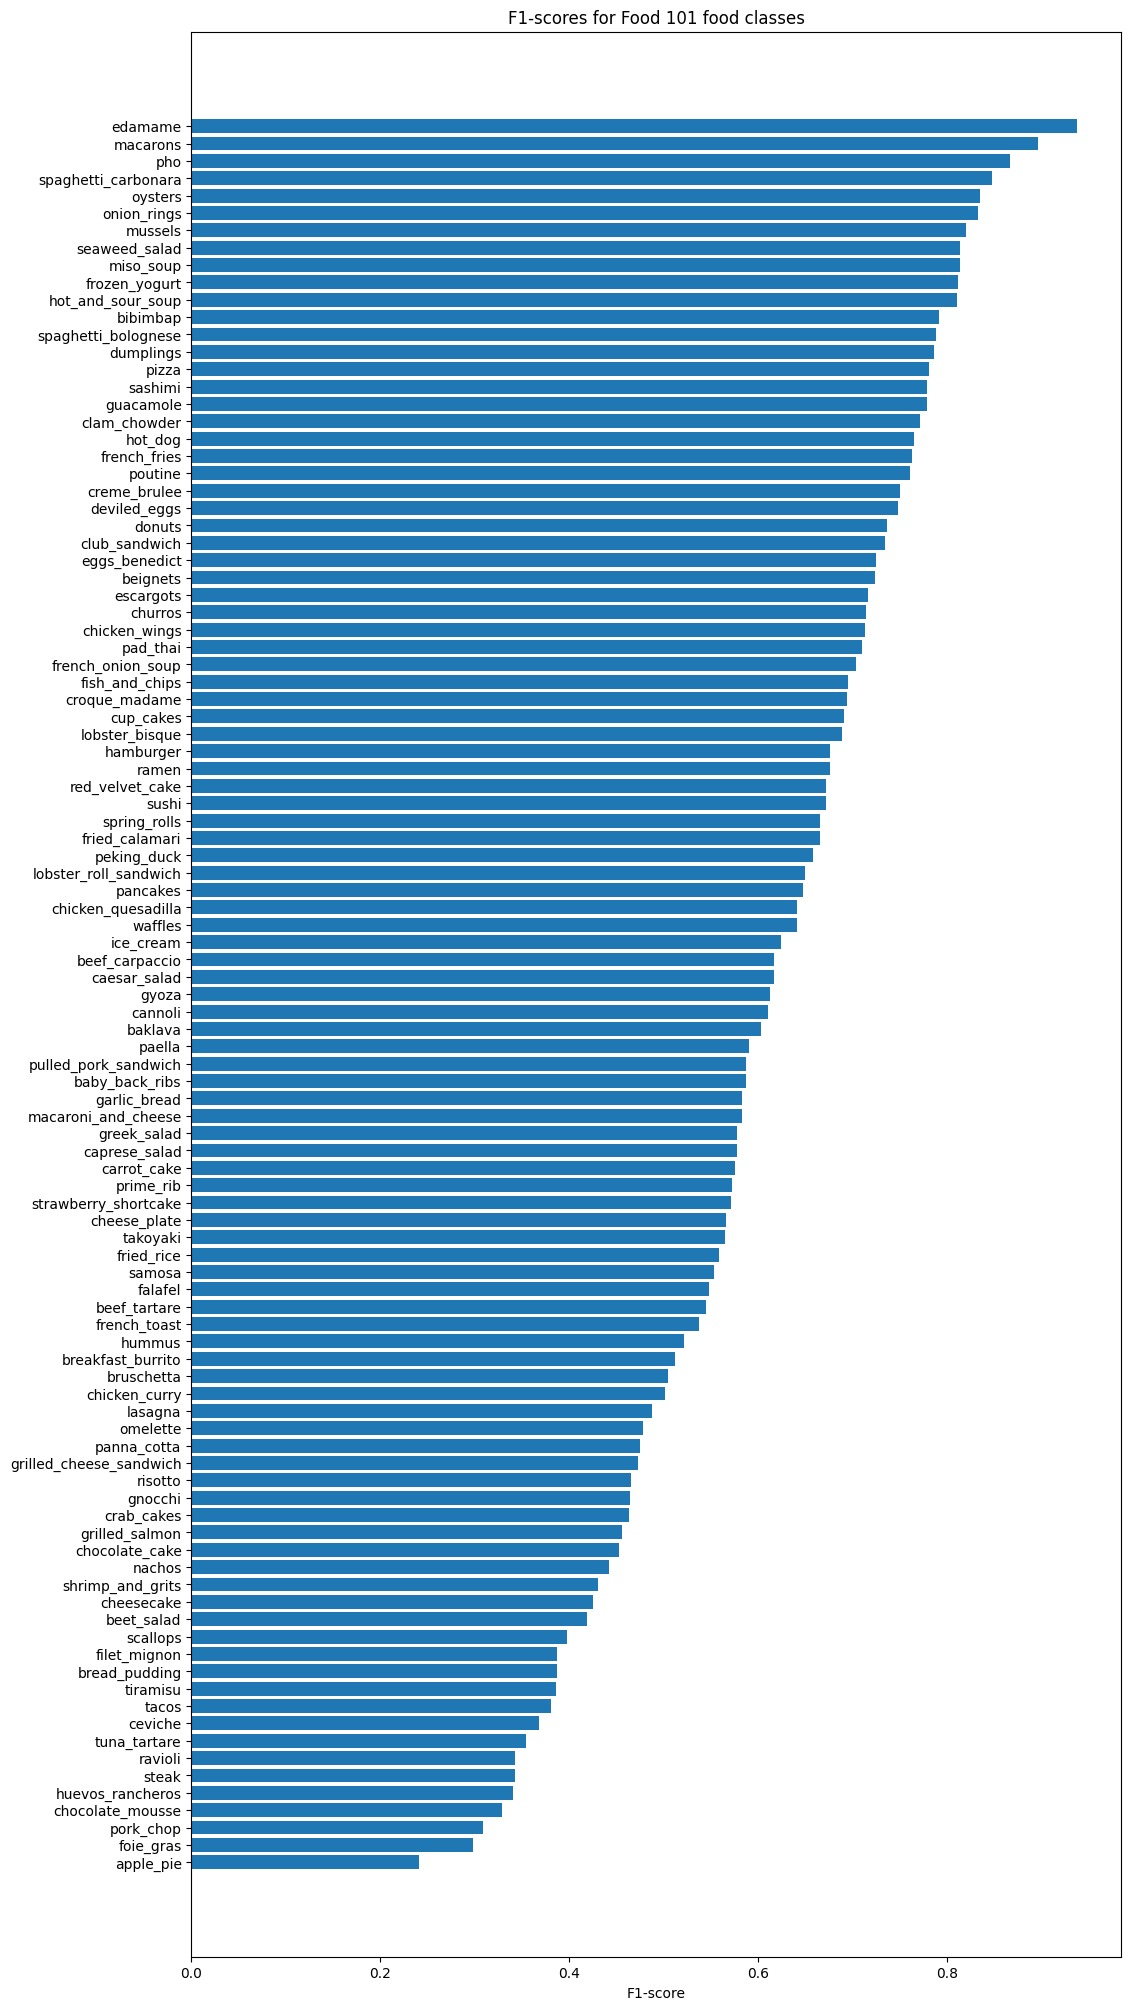

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores_df["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores_df["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for Food 101 food classes")
ax.invert_yaxis();

# Visualizing random samples

In [ ]:
def load_and_prep_img(filepath, img_shape=224, scale=True):
  """Reads-in an image from a file, turns it into a tensor
  and reshapes into specified shape (img_shape, img_shape,3)
  3 stands for R,G,B """

  # read-in an image with tf.io.read_file()
  img = tf.io.read_file(filepath)
  # turn an img into a tensor with **tf.io.decode_img()**
  img = tf.io.decode_image(img, channels=3)
  # resize the img tensor to fit-in the size of images from dataset
  img = tf.image.resize(img, [img_shape,img_shape])
  # scale the image if necessary (bring all the values between 0 and 1)
  if scale:
    return img/255.0
  else:
    # for instance for Efficientnet is not necessary to use scaling
    return img

1/1 [==============================] - 0s 28ms/step


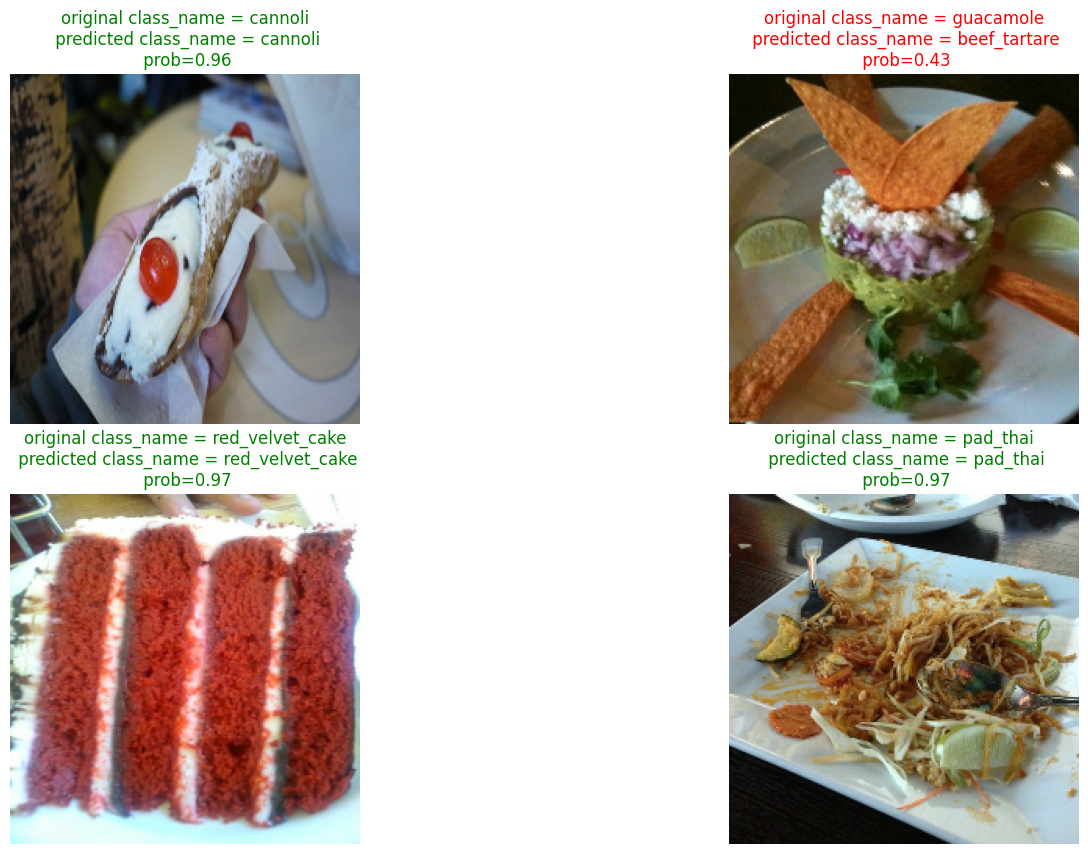

In [ ]:
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(17,10))

# visualize 4 random samples
for i in range(4):
  #  choose a random class
  class_name = random.choice(class_names)
  # choose a random image from a given class
  image_name = random.choice(os.listdir(test_dir+class_name))
  # set a file path for the image
  file_path = test_dir+class_name+"/"+image_name
  # load the chosen image and display it
  img = load_and_prep_img(filepath=file_path, scale=False)
  # make predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  #print(f'original class_name = {class_name}\n predicted class_name = {pred_class}\n\n')
  # plot the chosen img
  plt.subplot(2, 2, i+1)
  # matplotlib needs the rescaled img
  plt.imshow(img/255.)
  if class_name==pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f'original class_name = {class_name}\n predicted class_name = {pred_class}\n prob={pred_prob.max():.2f}', c=title_color);
  plt.axis("off");



# Visualize most wrong predictions

model outputs a class name with a very high probability but actually it's wrong!

* false positives
* flase negatives

it can reveal several problems:

- **label problem** -> original label is wrong but the model got it correct
- **confusing classes** -> need of more diverse and better images

knowing those examples let us improve our dataset

In [ ]:
# get all of the image filepaths
file_paths = []
for filepath in test_data.list_files(file_pattern=test_dir+"*/*.jpg", shuffle=False):
  file_paths.append(filepath.numpy())
file_paths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# create a DataFrame of those filepaths
import pandas as pd

pred_df = pd.DataFrame({"path": file_paths, "class_name": [class_names[i] for i in y_true], "label": y_true, "pred_class": [class_names[i] for i in preds], "pred_label": preds, "prediction_confidance":pred_probs.max(axis=1)})
pred_df


,path,class_name,label,pred_class,pred_label,prediction_confidance
0,b'/content/101_food_classes_10_percent/test/ap...,apple_pie,0,gyoza,52,0.847419
1,b'/content/101_food_classes_10_percent/test/ap...,apple_pie,0,apple_pie,0,0.964017
2,b'/content/101_food_classes_10_percent/test/ap...,apple_pie,0,apple_pie,0,0.959259
3,b'/content/101_food_classes_10_percent/test/ap...,apple_pie,0,pulled_pork_sandwich,80,0.658606
4,b'/content/101_food_classes_10_percent/test/ap...,apple_pie,0,prime_rib,79,0.367900
...,...,...,...,...,...,...
25245,b'/content/101_food_classes_10_percent/test/wa...,waffles,100,waffles,100,0.972823
25246,b'/content/101_food_classes_10_percent/test/wa...,waffles,100,cheese_plate,16,0.878028
25247,b'/content/101_food_classes_10_percent/test/wa...,waffles,100,waffles,100,0.537899
25248,b'/content/101_food_classes_10_percent/test/wa...,waffles,100,strawberry_shortcake,94,0.501950


In [ ]:
# find all wrong predictions and sort them in descending order
wrong_df = pred_df[pred_df["label"]!=pred_df["pred_label"]]
wrong_df = wrong_df.sort_values("prediction_confidance", ascending=False)
wrong_df

,path,class_name,label,pred_class,pred_label,prediction_confidance
21810,b'/content/101_food_classes_10_percent/test/sc...,scallops,87,cup_cakes,29,0.999997
231,b'/content/101_food_classes_10_percent/test/ap...,apple_pie,0,waffles,100,0.999995
15359,b'/content/101_food_classes_10_percent/test/lo...,lobster_roll_sandwich,61,hamburger,53,0.999988
23539,b'/content/101_food_classes_10_percent/test/st...,strawberry_shortcake,94,red_velvet_cake,83,0.999987
21400,b'/content/101_food_classes_10_percent/test/sa...,samosa,85,spring_rolls,92,0.999981
...,...,...,...,...,...,...
22303,b'/content/101_food_classes_10_percent/test/sh...,shrimp_and_grits,89,gnocchi,47,0.141998
15646,b'/content/101_food_classes_10_percent/test/ma...,macaroni_and_cheese,62,chicken_quesadilla,19,0.139136
6092,b'/content/101_food_classes_10_percent/test/cl...,clam_chowder,24,cheese_plate,16,0.137614
168,b'/content/101_food_classes_10_percent/test/ap...,apple_pie,0,pulled_pork_sandwich,80,0.128814


In [ ]:
wrong_df.columns

Index(['path', 'class_name', 'label', 'pred_class', 'pred_label',
       'prediction_confidance'],
      dtype='object')

In [ ]:
for i in wrong_df.head(4):
  print(type(i))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


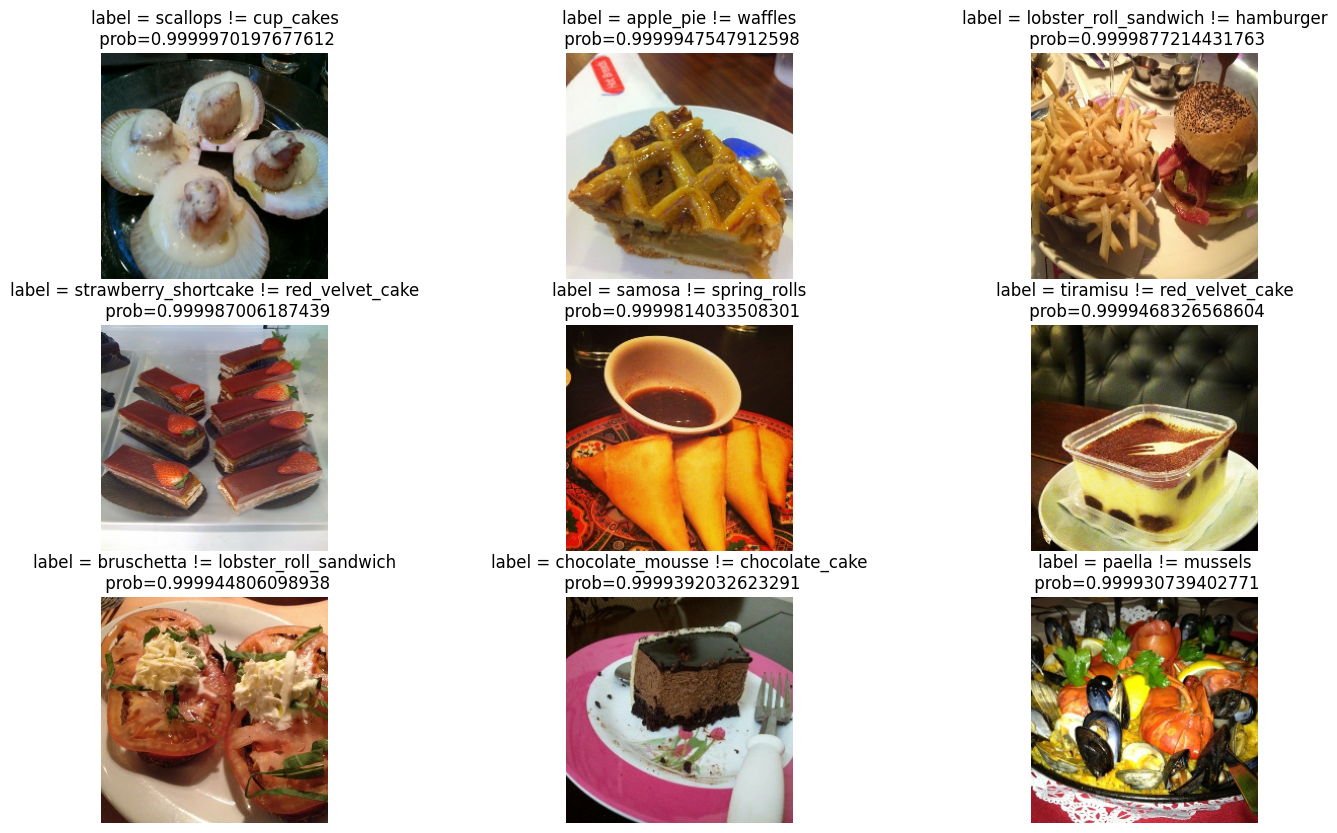

In [ ]:
# visualize the most wrong preds (high pred_prob but label mismatches)
plt.figure(figsize=(17,10))

num_of_img_to_view = 9

for i, row in enumerate(wrong_df[0:num_of_img_to_view].itertuples()):

  path = row[1]
  # load the chosen image and display it
  img = load_and_prep_img(filepath=path, scale=True)
  # plot the chosen img
  plt.subplot(3, 3, i+1)
  plt.imshow(img)
  #class_name = row[2]
  #pred_class = row[4]
  #pred_prob = row[6]
  _,_,label,_,pred_class,_,pred_prob = row

  plt.title(f'label = {label} != {pred_class}\n prob={pred_prob}');
  plt.axis("off");
